# Notebook 2

In [26]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
matplotlib.rcParams.update({'font.size': 18})
import numpy as np
from collections import Counter
from operator import itemgetter
import random
import seaborn as sns
import powerlaw
import itertools
plt.style.use('ggplot')
import warnings

# Ignore two specific warning messages from the powerlaw package. 
# Comment these lines to show warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

### Read the network and summary statistics

In [4]:
# read network as directed graph from edge list
G_reddit = pd.read_csv('2016.csv', delimiter=",")
G = nx.convert_matrix.from_pandas_edgelist(G_reddit, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)

# print summary of network
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 19478
Number of edges: 56378
Average in degree:   2.8944
Average out degree:   2.8944


### Degrees, in and out degree distributions

In [17]:
# An easy way to plot the content of the counters
#I create this function because I will plot a lot of probability distribution functions in this notebook
def plot_counter(counter,xlabel = '',ylabel = '',prob = True,**params):
    lists = sorted(counter.items(), key = itemgetter(1)) # sorted by value
    x, y = zip(*lists) # unpack the list of keys, counts
    p_y = y / np.sum(y) #probability of y
    

    
    if prob:
        y = p_y
    
    plt.clf()
    plt.subplot(121)
    plt.title('Linear Scale')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.plot(x, y, "ro")

    plt.subplot(122)
    plt.title('Logarithmic Scale')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.loglog(x, y, "ro")
    
    
    
    if params.get('has_legend',False):
        legend_text = xlabel + ' =' + params['xmeaning'] + '\n' + ylabel + ' =' + params['ymeaning']
        plt.annotate(legend_text, xy=(250, -50), xycoords='axes points',
            size=14, ha='left', va='top',
            bbox=dict(boxstyle='round', fc='w'))
    
    plt.show()

## In-Degree

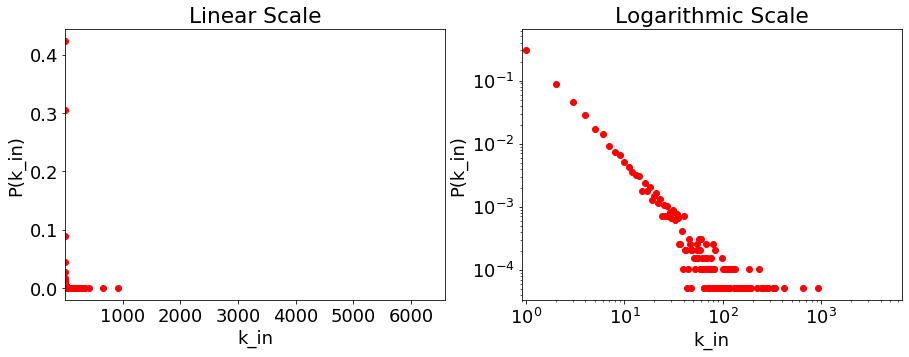

Largest in degree of any node in the collaboration network: 922


In [18]:
in_degree_count = Counter(dict(G.in_degree).values())

plot_counter(in_degree_count,xlabel =  'k_in',ylabel ='P(k_in)',
            has_xlim = True, left = 0.9, right = 6600)

print("Largest in degree of any node in the collaboration network: {}"
      .format(max(in_degree_count.keys())))

## Out-Degree

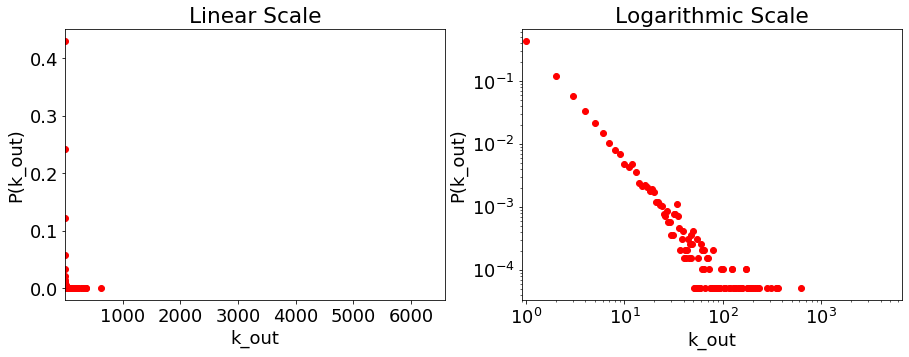

Largest out degree of any node in the collaboration network: 629


In [12]:
out_degree_count = Counter(dict(G.out_degree).values())

plot_counter(out_degree_count,xlabel =  'k_out',ylabel ='P(k_out)',
            has_xlim = True, left = 0.9, right = 6600)
print("Largest out degree of any node in the collaboration network: {}"
      .format(max(out_degree_count.keys())))

### Strongly and weakly connected components

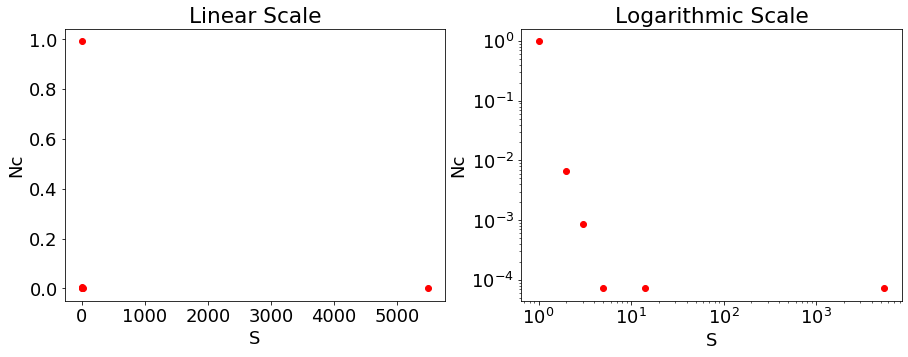

The largest strongly connected component in the network includes 5486 nodes


In [13]:
strong_component_lens = [len(c) for c in nx.strongly_connected_components(G)]
strong_component_size_count = Counter(strong_component_lens)
plot_counter(strong_component_size_count,xlabel = 'S', ylabel = 'Nc')
print("The largest strongly connected component in the network includes {} nodes".format(max(strong_component_size_count.keys())))

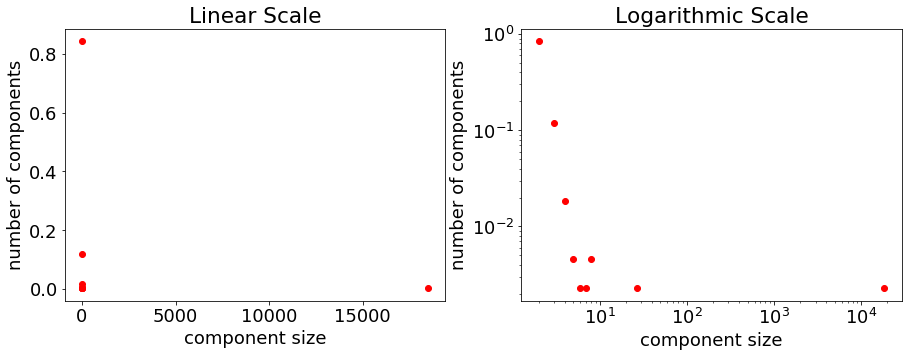

The largest weakly connected component in the network inculdes 18479 nodes


In [14]:
weak_component_lens = [len(c) for c in nx.weakly_connected_components(G)]
weak_component_size_count = Counter(weak_component_lens)
plot_counter(weak_component_size_count,xlabel = "component size", ylabel = "number of components")
print("The largest weakly connected component in the network inculdes {} nodes"
      .format(max(weak_component_size_count.keys())))

### Shortest paths

In [19]:
def get_largest_strong_component(DiGraph):
    
    components_sorted = sorted( nx.strongly_connected_components(DiGraph) , key=len, reverse=True )
    return DiGraph.subgraph( components_sorted[0] )

def get_sampled_shortest_path_lens(Graph , number_of_paths = 10000):
    
    path_lens = []
    
    for i in range(number_of_paths):
        
        #if i % 100 == 0:
        #   print(i)
        
        nodes = random.sample(Graph.nodes(),2) # RS: explain that with this you avoid taking the shortest path between a node and itself
        shortest_path = nx.shortest_path(Graph, source=nodes[0], target=nodes[1])
        path_lens.append(len(shortest_path))
    
    return path_lens
    
def hist_counter(counter,xlabel = '',ylabel = '',prob = True,**params):
    lists = sorted(counter.items(), key = itemgetter(1)) # sorted by value
    x, y = zip(*lists) # unpack the list of keys, counts
    p_y = y / np.sum(y) #probability of y
    
    if prob:
        y = p_y

    plt.clf()
    plt.subplot(121)
    plt.title('Shortest path distribution')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(1, max(x)+1, 1.0))
    
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
        
    plt.bar(x ,y)
    
    if params.get('has_legend',False):
        legend_text = xlabel + ' =' + params['xmeaning'] + '\n' + ylabel + ' =' + params['ymeaning']
        plt.annotate(legend_text, xy=(250, -50), xycoords='axes points',
            size=14, ha='left', va='top',
            bbox=dict(boxstyle='round', fc='w'))

    plt.show()    

largest_strong_component = get_largest_strong_component(G)
shortest_path_len_counts = Counter(get_sampled_shortest_path_lens(largest_strong_component))

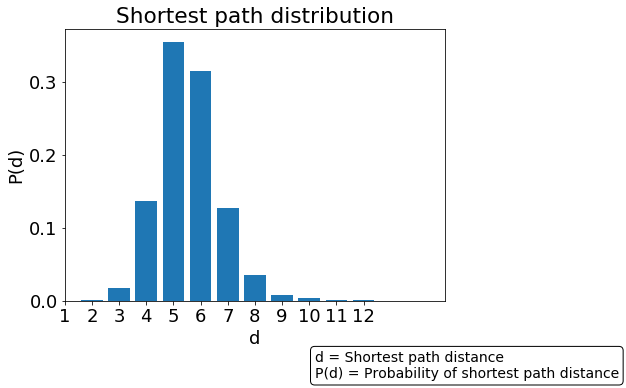

The longest sampled shortest path in the largest connected component of the network is 12 long.


In [20]:
hist_counter(shortest_path_len_counts,ylabel = "P(d)",xlabel = "d",has_legend = True
             ,xmeaning = ' Shortest path distance', ymeaning = ' Probability of shortest path distance',
            has_xlim = True, left = 1, right = 15)

print("The longest sampled shortest path in the largest connected component of the network is {} long."
      .format(max(shortest_path_len_counts.keys()))) 

### Clustering coefficient

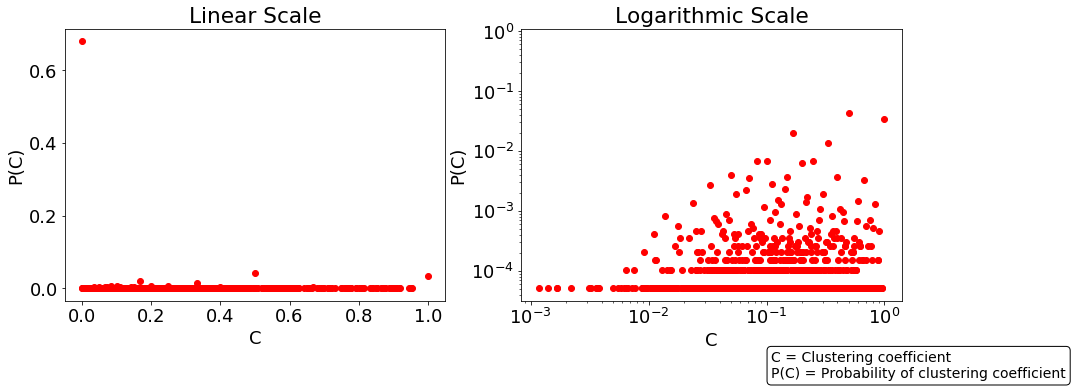

The global clustering coefficient of the network: 0.1022120308022363


In [22]:
#Clustering coefficient?
nodes_clustering = nx.clustering(G)
clustering_count = Counter(nodes_clustering.values())
plot_counter(clustering_count,xlabel = "C", ylabel = "P(C)" ,has_legend = True,
             xmeaning = ' Clustering coefficient', ymeaning = ' Probability of clustering coefficient')
clustering_coefficient = nx.average_clustering(G)
print("The global clustering coefficient of the network: {}".format(clustering_coefficient))

# Notebook 3

In [32]:
def plot_cumulative_distribution(values, bins = 100,xlabel = '',ylabel = '', 
                                 title = 'Complementary cumulative distribution',show = True ,hide_hist = True):
    """
    Shows the 1 - cumulative distribution of values.
    """
    n,x, _ = plt.hist(values , density= True, cumulative = True, bins = bins)
    
    if hide_hist:
        plt.close()
    
    # This line finds the middle of the histogram bins 
    bin_centers = 0.5*(x[1:]+x[:-1])
    #This line 1-bin height so this plot becomes a complementary cumulative distribution
    y = [1 - v for v in n] 
    
    
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().set_yscale("symlog", linthresh=0.00001)
    plt.gca().set_xscale("log")
    
    if show:
        plt.plot(bin_centers,y,'ro') ## using bin_centers rather than edges
        plt.show()
    else:
        plt.close()

        return bin_centers, y

    
def log_binned_prob_hist(values , bins_n = 15, logged = False,xlabel = 'k', ylabel = 'P(k)',
                         title = "Logarithmically binned degree distribution",show = True ,**params ):
    """
    This function shows a logarithmically binned histogram the input(values) is a list of integers or floats
    """
    maximum_value = params.get('maximum_value', max(values))          
    
    #This line is to create weights which are used to normalise input data so the output of the function is
    # a probability distribution
    weights = np.ones_like(values) / (len(values))
    
    #np.logspace generater num samples equally space out on a logscale 
    n,x, _  = plt.hist(values, bins=np.logspace(np.log10(1), np.log10(maximum_value), num = bins_n )
                       , weights = weights, log = True)
    plt.close()
    bin_centers = 0.5*(x[1:]+x[:-1])
    plt.gca().set_yscale("symlog", linthresh=0.0001)
    plt.gca().set_xscale("log")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.scatter(bin_centers,n)
    
    if show:
        plt.show()
    else:
        plt.close()
        return bin_centers ,n
    
# An easy way to plot the content of the counters
#I create this function because I will plot a lot of probability distribution functions in this notebook
def plot_counter(counter,degrees ,xlabel = '',ylabel = '',prob = True,**params):
    """
    The counter object is dictionary like object which containt a measure like a degree of a node as keys and
    the times it occured as values
    """
    
    lists = sorted(counter.items(), key = itemgetter(1)) # sorted by value
    x, y = zip(*lists) # unpack the list of keys, counts
    
    
    # If it is a probabilty distribution use the normalised y values
    p_y = y / np.sum(y) #probability of y
    if prob:
        y_s = p_y
    x_c, y_c = plot_cumulative_distribution(degrees ,show = False)
    x_l, y_l =log_binned_prob_hist(degrees ,show = False)
    
    plt.clf()
    
    plt.subplot(221)
    plt.title('Linear Scale')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.plot(x,y_s, "ro")
    
    
    plt.subplot(222)
    plt.title('Logarithmic Scale')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.gca().set_yscale("symlog", linthresh=0.01)
    plt.gca().set_xscale("log")
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.loglog(x,y_s, "ro")

    plt.subplot(223)
    
    plt.gca().set_yscale("symlog", linthresh=0.01)
    plt.gca().set_xscale("log")
    plt.title("Logarithmically binned distribution")
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.plot(x_l, y_l,'ro')
    
    plt.subplot(224)
    
    plt.title('Complementary cumulative distribution')
    plt.xlabel('x')
    plt.ylabel('P(x>k)')
    plt.gca().set_yscale("symlog", linthresh=0.01)
    plt.gca().set_xscale("log")
    plt.plot(x_c, y_c,'ro')
    
    # This part is responsable for the legend
    if params.get('has_legend', False):
        legend_text = xlabel + ' =' + params['xmeaning'] + '\n' + ylabel + ' =' + params['ymeaning']
        plt.annotate(legend_text, xy=(250, -50), xycoords='axes points',
            size=14, ha='left', va='top',
            bbox=dict(boxstyle='round', fc='w'))
   
    plt.show()

## In-Degree Distribution

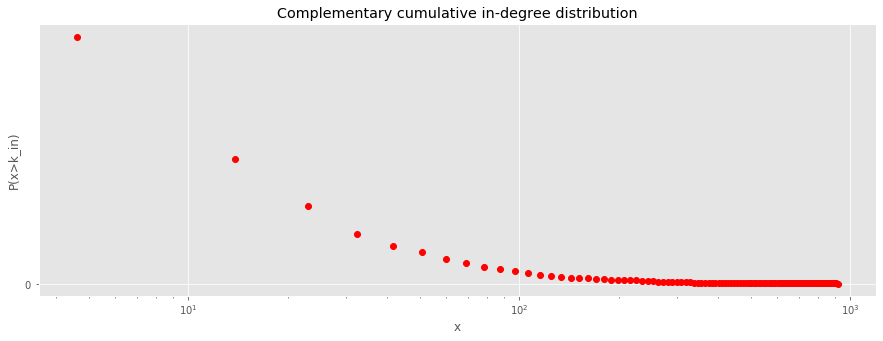

In [27]:
email_in_degrees = list(dict(G.in_degree).values())
plot_cumulative_distribution(email_in_degrees,xlabel = 'x',ylabel = 'P(x>k_in)', 
                             title = 'Complementary cumulative in-degree distribution' )

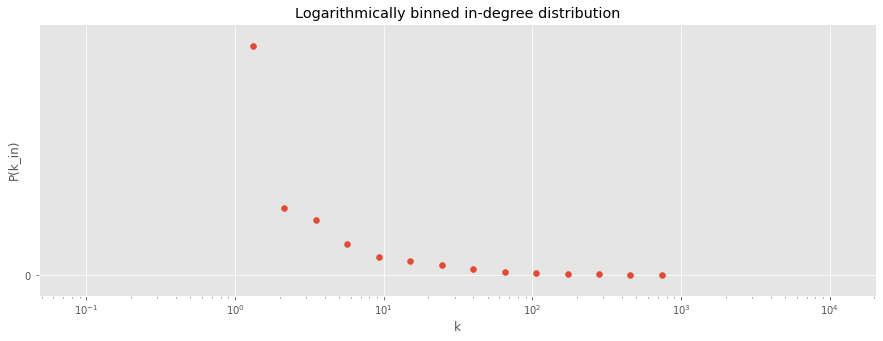

In [30]:
log_binned_prob_hist(email_in_degrees, logged = True, ylabel = 'P(k_in)', 
                     title = 'Logarithmically binned in-degree distribution')

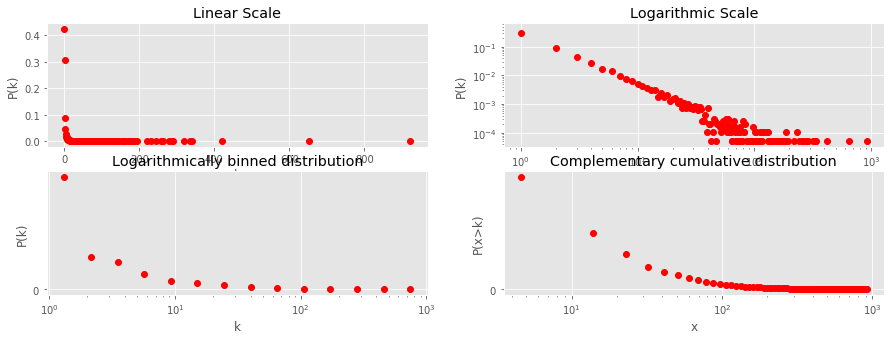

Largest in degree of any node in the collaboration network: 922


In [33]:
in_degree_count = Counter(dict(G.in_degree).values())

plot_counter(in_degree_count,email_in_degrees,xlabel =  'k_in',ylabel ='P(k_in)')

print("Largest in degree of any node in the collaboration network: {}"
      .format(max(in_degree_count.keys())))

## Out-Degree Distribution

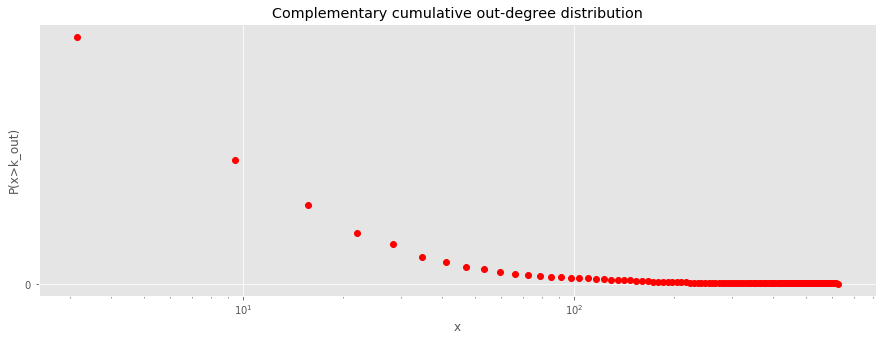

In [35]:
email_out_degrees = list(dict(G.out_degree).values())

plot_cumulative_distribution(email_out_degrees,xlabel = 'x',ylabel = 'P(x>k_out)', 
                             title = 'Complementary cumulative out-degree distribution' )

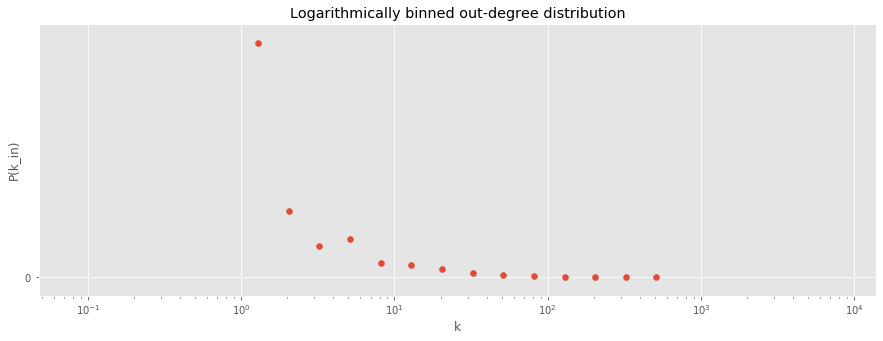

In [36]:
log_binned_prob_hist(email_out_degrees, logged = True, ylabel = 'P(k_in)', 
                     title = 'Logarithmically binned out-degree distribution')

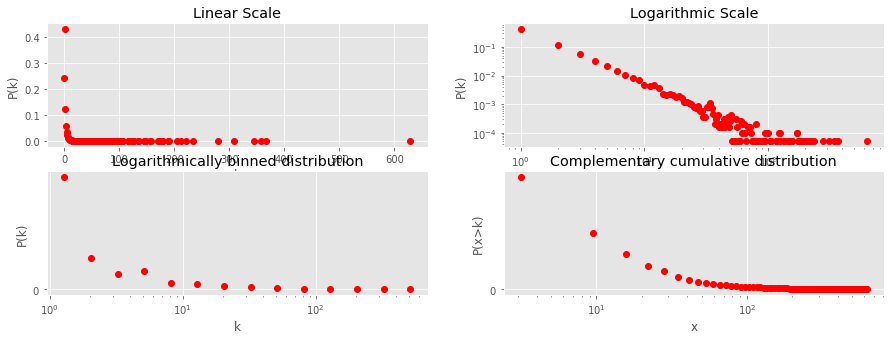

Largest in degree of any node in the collaboration network: 629


In [37]:
out_degree_count = Counter(dict(G.out_degree).values())

plot_counter(out_degree_count,email_out_degrees,xlabel =  'k_in',ylabel ='P(k_in)')

print("Largest in degree of any node in the collaboration network: {}"
      .format(max(out_degree_count.keys())))

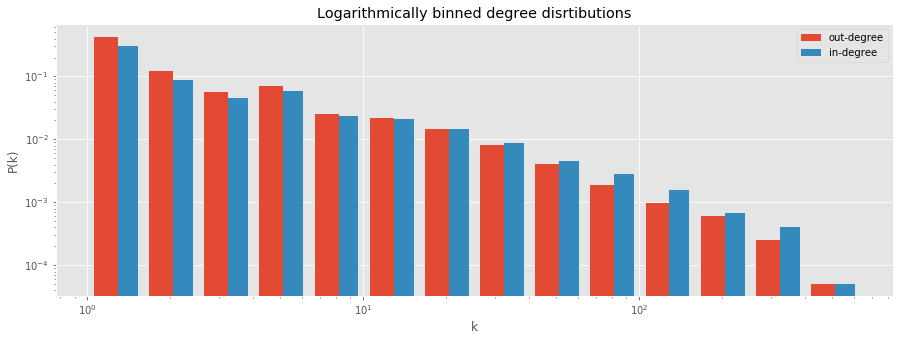

In [38]:
weights = np.ones_like(email_out_degrees) / (len(email_out_degrees))

names = ['out-degree', 'in-degree']
plt.hist([email_out_degrees,email_in_degrees], 
         bins=np.logspace(np.log10(1),np.log10(max(email_out_degrees)),num = 15), weights = [weights,weights], label=names)
plt.gca().set_xscale("log")
plt.title("Logarithmically binned degree disrtibutions")
plt.legend()
plt.ylabel("P(k)")
plt.xlabel('k')

plt.yscale('log')
plt.show()

## Centrality measures

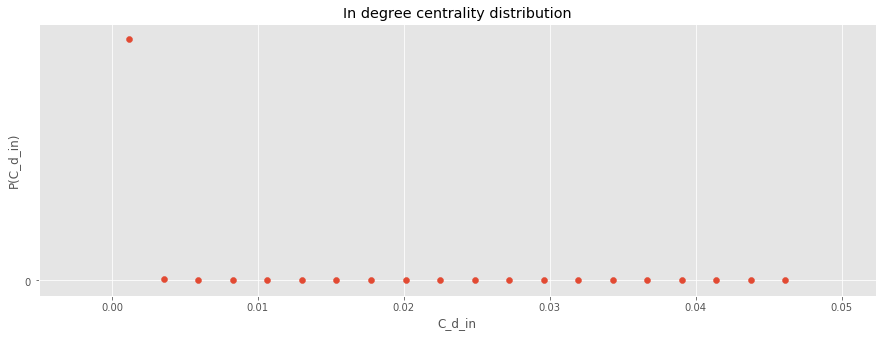

0.04733788571135185


In [40]:
def get_largest_strong_component(DiGraph):
    
    components_sorted = sorted(nx.strongly_connected_components(DiGraph) , key=len, reverse=True )
    return DiGraph.subgraph(components_sorted[0])

email_betweeness = nx.betweenness_centrality(G, k = 1000)
email_in_degree_cent = nx.in_degree_centrality(G)
email_out_degree_cent = nx.out_degree_centrality(G)
email_sampled_nodes = random.sample(get_largest_strong_component(G).nodes(),1000)

email_closeness = {}
cnt = 0
for node in email_sampled_nodes:
   #cnt += 1
   #if  cnt%100 == 0:
   #    print(cnt)
    email_closeness[node] = nx.closeness_centrality(get_largest_strong_component(G),u = node)

email_eigen = nx.eigenvector_centrality(G,max_iter = 200)

weights = np.ones_like(list(email_in_degree_cent.values())) / (len(email_in_degree_cent.values()))
n,x, _ = plt.hist(list(email_in_degree_cent.values()), bins = 20, weights = weights)
plt.close()
bin_centers = 0.5*(x[1:]+x[:-1])
plt.gca().set_yscale("symlog", linthresh=0.0000001)
plt.scatter(bin_centers,n)
plt.title('In degree centrality distribution')
plt.xlabel('C_d_in')
plt.ylabel('P(C_d_in)')
plt.show()
print(max(email_in_degree_cent.values()))

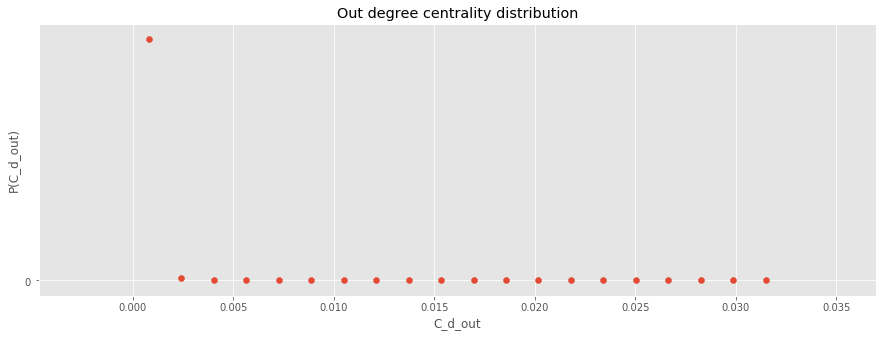

0.032294501206551314


In [41]:
weights = np.ones_like(list(email_out_degree_cent.values())) / (len(email_out_degree_cent.values()))
n,x, _ =plt.hist(list(email_out_degree_cent.values()), bins = 20, weights = weights)
plt.close()
bin_centers = 0.5*(x[1:]+x[:-1])
plt.gca().set_yscale("symlog", linthresh=0.001)
plt.scatter(bin_centers,n)
plt.title('Out degree centrality distribution')
plt.xlabel('C_d_out')
plt.ylabel('P(C_d_out)')
plt.show()
print(max(email_out_degree_cent.values()))

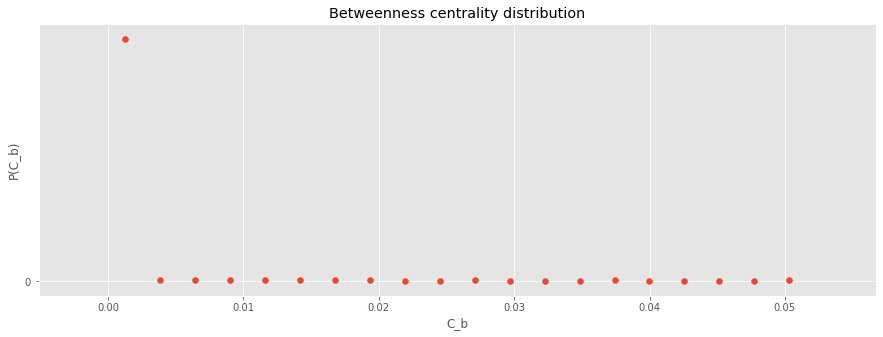

0.05161156181641827


In [42]:
weights = np.ones_like(list(email_betweeness.values())) / (len(email_betweeness.values()))
n,x, _ =plt.hist(list(email_betweeness.values()), bins = 20, weights = weights)
plt.close()
bin_centers = 0.5*(x[1:]+x[:-1])
plt.gca().set_yscale("symlog", linthresh=0.000001)
plt.scatter(bin_centers,n)
plt.title('Betweenness centrality distribution')
plt.xlabel('C_b')
plt.ylabel('P(C_b)')
plt.show()
print(max(email_betweeness.values()))

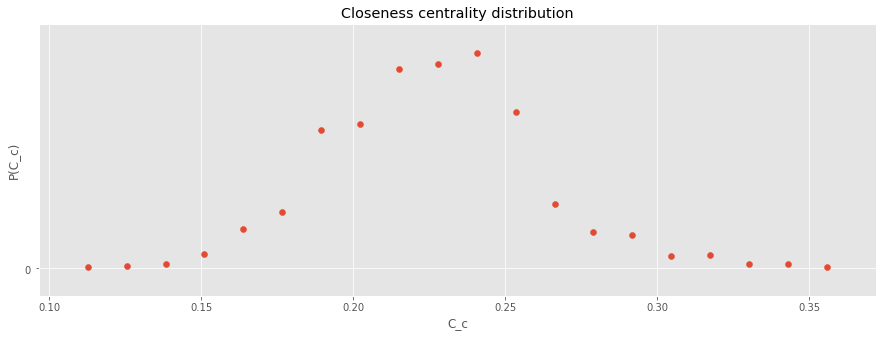

0.36221356402298094


In [43]:
weights = np.ones_like(list(email_closeness.values())) / (len(email_closeness.values()))
n,x, _ =plt.hist(list(email_closeness.values()), bins = 20, weights = weights)
plt.close()
bin_centers = 0.5*(x[1:]+x[:-1])
plt.gca().set_yscale("symlog", linthresh=0.01)
plt.scatter(bin_centers,n)
plt.title('Closeness centrality distribution')
plt.xlabel('C_c')
plt.ylabel('P(C_c)')
plt.show()
print(max(email_closeness.values()))

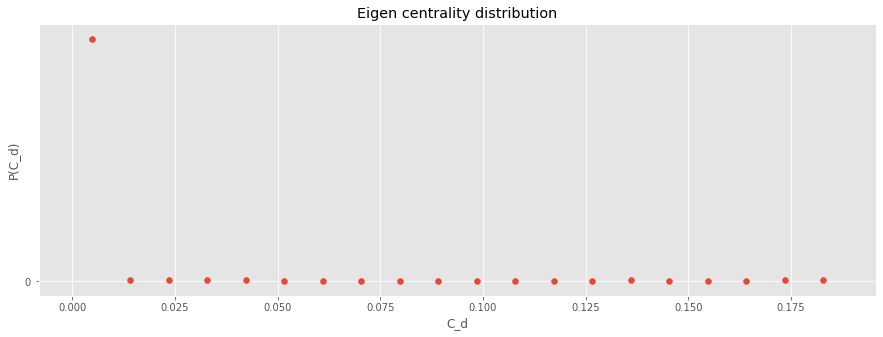

0.18751735945040915


In [44]:
weights = np.ones_like(list(email_eigen.values())) / (len(email_eigen.values()))
n,x, _ =plt.hist(list(email_eigen.values()), bins = 20, weights = weights)
plt.close()
bin_centers = 0.5*(x[1:]+x[:-1])
plt.gca().set_yscale("symlog", linthresh=0.001)
plt.scatter(bin_centers,n)
plt.title('Eigen centrality distribution')
plt.xlabel('C_d')
plt.ylabel('P(C_d)')
plt.show()
print(max(email_eigen.values()))

In [45]:
vectors = {}
vectors['in_degree_centralities'] = []
vectors['out_degree_centralities'] = []
vectors['betweenness_centralities'] = []
vectors['closeness_centralities'] = []
vectors['eigen_centralities'] = []
vectors['keys'] = []
for key in email_closeness.keys():
    vectors['keys'].append(key)
    vectors['in_degree_centralities'].append(email_in_degree_cent[key])
    vectors['out_degree_centralities'].append(email_out_degree_cent[key])
    vectors['betweenness_centralities'].append(email_betweeness[key])
    vectors['closeness_centralities'].append(email_closeness[key])
    vectors['eigen_centralities'].append(email_eigen [key])
centrality_df = pd.DataFrame.from_dict(vectors,orient='index').transpose()
centrality_df = centrality_df.set_index('keys')

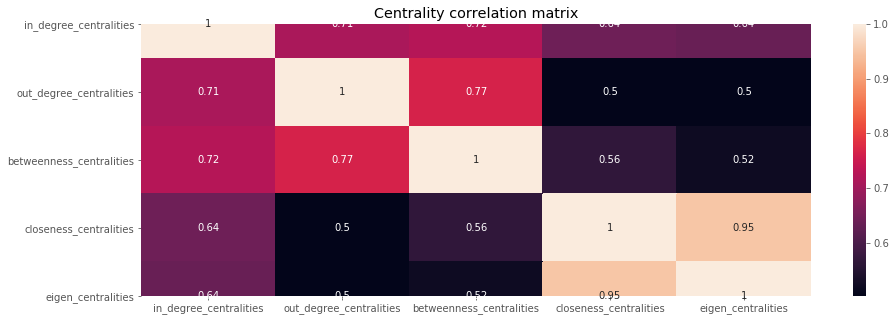

In [48]:
corr_mat= centrality_df.astype(float).corr('spearman')
sns.heatmap(corr_mat, annot = True)
plt.title('Centrality correlation matrix')
plt.show()

# Notebook 4

In [28]:
def compare_fits(fitoutput):
    """
    Prints the pairwise comparison of distribution fits from the output of powerlaw.Fit()
         @fitoutput: Output of powerlaw.Fit() to the degree distribution of a network 
    """
    distribution_names = ['power_law', 'exponential', 'lognormal', 'truncated_power_law']

    # loop over each pairwise combination of the three distributions
    for f1, f2 in itertools.combinations(distribution_names, 2):
        R, p = fitoutput.distribution_compare(f1, f2)
        print("Result of {} vs. {}: R = {}, p = {}"
             .format(f1, f2, R, p))
        
    # print optimal parameters
    print("\n\nOPTIMAL PARAMETERS:")
    print(" * Power law: alpha = {:.6}".format(fitoutput.power_law.alpha))
    print(" * Lognormal:  mu = {:.6}, sigma = {:.6}".format(fitoutput.lognormal.mu, fitoutput.lognormal.sigma))
    print(" * Exponential: lambda = {:.6}".format(fitoutput.exponential.Lambda))
    print(" * Power law w. exponential cutoff: lambda = {:.6}, alpha = {:.6}"
          .format(fitoutput.truncated_power_law.Lambda, fitoutput.truncated_power_law.alpha))
    
def plot_ccdf(fitoutput, title="CCDF"):
    """
    Plots complement of a cumulative distribution (CCDF) from the output of a 
    degree distribution fitted using the powerlaw package
        @fitoutput: Output of powerlaw.Fit() to the degree distribution of a network 
    """
    plt.figure()
    fig1 = fitoutput.plot_ccdf(label='CCDF', linestyle='--', marker='o')
    plt.title(title)
    plt.legend()
    plt.ylim(0.001, 1.2)
    plt.xlabel('$x$')
    plt.ylabel('$P(k>=x)$')
    plt.show()
    
def plot_ccdf_with_fits(fitoutput_original, fitoutput_configuration):
    """
    Plots complement of a cumulative distribution (CCDF) with distributions fits from the output of two 
    degree distributions fitted using the powerlaw package
        @fitoutput_original: Output of powerlaw.Fit() to the degree distribution of a real-world network 
        @fitoutput_configuration: Output of powerlaw.Fit() to the degree distribution of a configuration model
    """
    # initilize subplots
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
    
    # plot CCDF of original network
    fitoutput_original.plot_ccdf(ax=ax1, label='Original network: CCDF', linestyle='--', marker='v')
    
    # add fitted powerlaw,lognormal CCDF plots as dashed lines
    fitoutput_original.power_law.plot_ccdf(ax=ax1, color='#f54e42', linestyle='-', 
                                           label='Original network: power-law fit')

    fitoutput_original.lognormal.plot_ccdf(ax=ax1, color='#f5bc42', linestyle='-', 
                                           label='Original network: lognormal fit')

    ax1.set_title("Degree distribution CCDF for network and corresponding configuration model")
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$P(k>=x)$')
    
    
    # repeat for configuration model
    fitoutput_configuration.plot_ccdf(ax=ax1, label='Configuration: CCDF', linestyle='--', marker='^')
    
    # add fitted powerlaw, lognormal CCDF plots as dashed lines
    fitoutput_configuration.power_law.plot_ccdf(ax=ax1, color='#085087', linestyle='--', 
                                                label='Configuration: power-law fit')
    fitoutput_configuration.lognormal.plot_ccdf(ax=ax1, color='#5e98c4', linestyle='--', 
                                                label='Configuration: lognormal fit')

    ax1.legend()

    plt.show()  

/home/alanispani/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


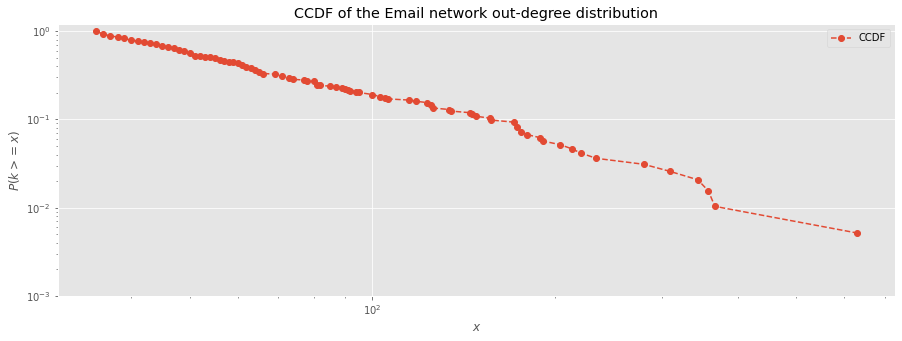

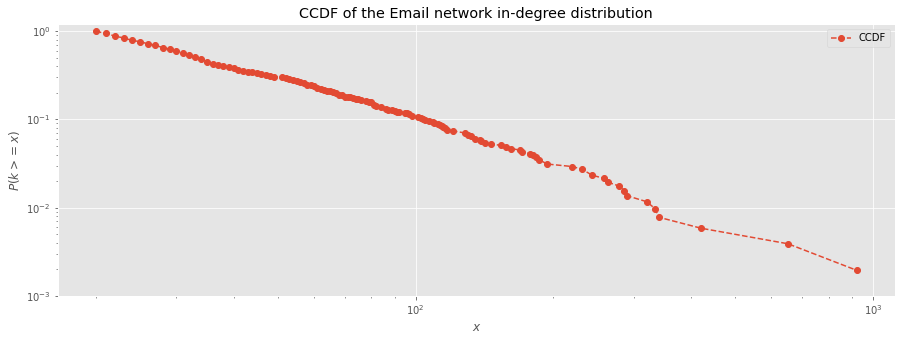

In [8]:
# Extract the list of all node degrees in the network for in- and out-degrees
email_degrees_out = np.array(list(dict(G.out_degree).values()))
email_degrees_in = np.array(list(dict(G.in_degree).values()))

# fit each degree distribution using powerlaw
email_fitoutput_out = powerlaw.Fit(email_degrees_out, verbose=False)
email_fitoutput_in = powerlaw.Fit(email_degrees_in, verbose=False)

# plot CCDF of the email network distributions separately
plot_ccdf(email_fitoutput_out, "CCDF of the Email network out-degree distribution")
plot_ccdf(email_fitoutput_in, "CCDF of the Email network in-degree distribution")

In [9]:
# Positive R means better fit for the first distribution. If p > 0.05, the algorithm can't determine what's better.
print("Comparisons of distribution fits for the Email network out-degrees:\n")
compare_fits(email_fitoutput_out)

Comparisons of distribution fits for the Email network out-degrees:

Result of power_law vs. exponential: R = 26.124229400400207, p = 0.005637391086128093
Result of power_law vs. lognormal: R = -0.2087373586837704, p = 0.66595526458709


/home/alanispani/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Assuming nested distributions


Result of power_law vs. truncated_power_law: R = -0.6460920033712223, p = 0.25564585584344957
Result of exponential vs. lognormal: R = -26.332966759083977, p = 0.0034512101341367648
Result of exponential vs. truncated_power_law: R = -26.77032140377138, p = 0.002384541001570138
Result of lognormal vs. truncated_power_law: R = -0.4373546446874519, p = 0.11421468808385465


OPTIMAL PARAMETERS:
 * Power law: alpha = 2.67367
 * Lognormal:  mu = -6.46043, sigma = 2.58213
 * Exponential: lambda = 0.0229644
 * Power law w. exponential cutoff: lambda = 0.00149025, alpha = 2.46061


In [10]:
print("Comparisons of distribution fits for the Email network in-degrees:\n")
compare_fits(email_fitoutput_in)

Comparisons of distribution fits for the Email network in-degrees:

Result of power_law vs. exponential: R = 98.06012044695927, p = 0.00010506493424496242
Result of power_law vs. lognormal: R = -1.2506427278158885, p = 0.3294298888938907
Result of power_law vs. truncated_power_law: R = -2.161346461171618, p = 0.03760736205652149
Result of exponential vs. lognormal: R = -99.31076317477536, p = 4.0525474086066536e-05
Result of exponential vs. truncated_power_law: R = -100.22146690813062, p = 2.7919067853027635e-05
Result of lognormal vs. truncated_power_law: R = -0.9107037333557724, p = 0.10455753319135673


OPTIMAL PARAMETERS:
 * Power law: alpha = 2.42363
 * Lognormal:  mu = -3.88385, sigma = 2.3994
 * Exponential: lambda = 0.0291249
 * Power law w. exponential cutoff: lambda = 0.00162214, alpha = 2.24759


Assuming nested distributions


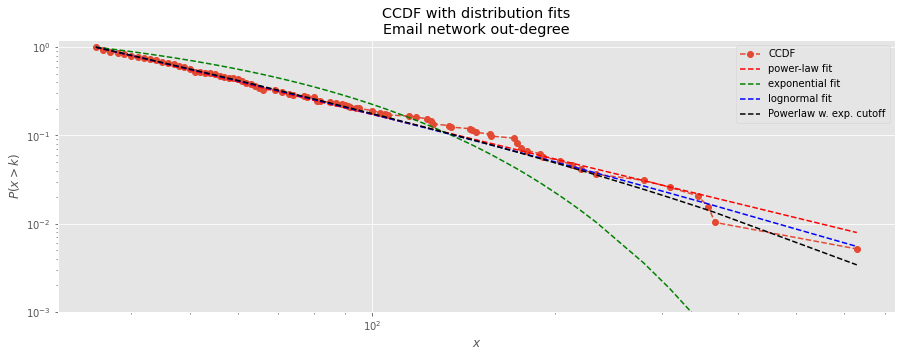

In [11]:
plot_ccdf_with_fits(email_fitoutput_out, "CCDF with distribution fits\nEmail network out-degree")

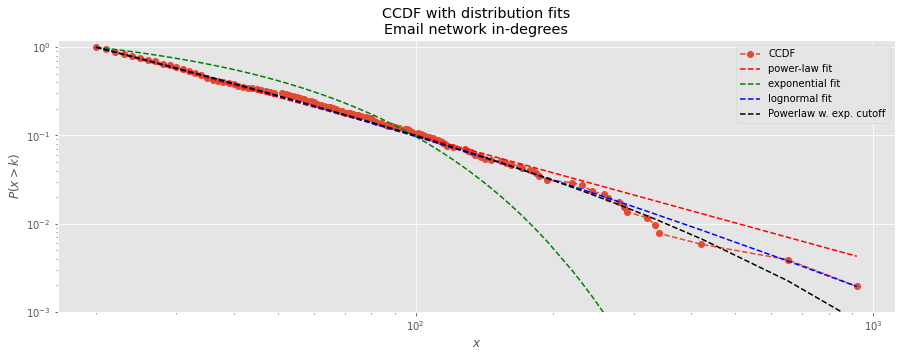

In [12]:
plot_ccdf_with_fits(email_fitoutput_in, "CCDF with distribution fits\nEmail network in-degrees")

## Contructing a random network null model
 
*Network science aims to build models that reproduce the properties of real networks.*   
-Barabási, Network Science book

Random network theory embraces the apparent randomness in real netwoorks by constructing and characterizing networks that are truly random. The usefulness of random networks from a network science perspective is described in Chapter 3 of the Network Science book. 

The Network Science book defines random networks in two ways:

$G(N, L)$ Model: N labeled nodes are connected with L randomly placed links. Erdős and Rényi used this definition in their string of papers on random networks.  
NetworkX implementation: [`gnm_random_graph`](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html#networkx.generators.random_graphs.gnm_random_graph)


$G(N, p)$ Model: Each pair of N labeled nodes is connected with probability p, a model introduced by Gilbert.  
NetworkX implementation: [`gnp_random_graph`](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html#networkx.generators.random_graphs.gnp_random_graph)


In [13]:
def construct_random_graph(G):
    """
    Constructs an Erdős-Rényi random network null model for a NetworkX graph. 
    Copies node attributes from G to random graph.
        @G: NetworkX Graph or DiGraph object
    Returns
        NetworkX Graph or DiGraph object with connections chosen uniformly at random
    """
    
    # extract number of nodes and edges
    num_nodes = nx.number_of_nodes(G)
    num_edges = nx.number_of_edges(G)
    
    # extract list of nodes in original graph
    nodes = dict(G.nodes(data=True))
    
    # initilize mapping between original node name and idx value in random graph
    node_idx_map = {}
    
    idx = 0
    random_graph_node_attributes = {}
    
    # loop over each node and corresponding attributes in original graph
    for name, attributes in nodes.items():
        attribs = attributes
        
        # set name/id in original graph as 'original_id' attribute 
        attribs['original_id'] = name
        random_graph_node_attributes[idx] = attribs
        
        # update node -> idx mapping and increment idx
        node_idx_map[name] = idx
        idx += 1
        
    # construct random graph
    G_random = nx.gnm_random_graph(n=num_nodes, m=num_edges, seed=42, directed=nx.is_directed(G))
    
    # add node attributes from dict
    nx.set_node_attributes(G_random, values=random_graph_node_attributes)
    
    return G_random

In [14]:
G_collab_random = construct_random_graph(G)
print(nx.info(G_collab_random))

Name: 
Type: DiGraph
Number of nodes: 19478
Number of edges: 56378
Average in degree:   2.8944
Average out degree:   2.8944


In [15]:
global_reddit = nx.average_clustering(G)
global_cc_random = nx.average_clustering(G_collab_random)

print("The Reddit network has a global CC of {:.6}".format(global_reddit))
print("Its corresponding random null model has a global CC of {:.4}".format(global_cc_random))

The Reddit network has a global CC of 0.102212
Its corresponding random null model has a global CC of 0.0001359


This way we can comfortably state that the Collaboration network has a higher degree of clustering than what could be expected from a random graph sharing a similar number of nodes and edges.   


Similarly, we can compare the average shortest path lengths of each network's largest connected component: 


In [16]:
def compare_distributions(title, dist1, dist2, xlabel, log=False, bins=20):
    """
    Plots two distributions side-by-side. 
    Plots histogram output as scatter plot
        @title: plot title
        @dist1 (list): distribution from original network
        @dist2 (list): ditribution from random network null model
        @xlabel (str): label on x-axis
        @log (boolean): If True, logscales y-axis
        @bins (int): number of histogram bins
    """
        
    # get histogram scatter points of distribution 1
    n_1, x_1, _ = plt.hist(dist1, bins = bins)
    bin_centers_1 = 0.5*(x_1[1:]+x_1[:-1])
    plt.close()
    
    # get histogram scatter points of distribution 2
    n_2, x_2, _ = plt.hist(dist2, bins = bins)
    bin_centers_2 = 0.5*(x_2[1:]+x_2[:-1])
    plt.close()
    
    # initilize subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # set y logscale if specified
    if log:
        ax1.set_yscale("symlog", linthresh=0.01)
        ax2.set_yscale("symlog", linthresh=0.01)

    fig.suptitle(title)
    
    # plot distribution from original network
    ax1.scatter(bin_centers_1, n_1)
    ax1.set_title("Original network")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("Frequency")
    ax1.axvline(x=np.mean(dist1), label='Mean: {:.3}'.format(np.mean(dist1)), color='#878686', linestyle='--')
    ax1.legend()
    
    # plot distribution from random network
    ax2.scatter(bin_centers_2, n_2)
    ax2.set_title("Random network")
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel("Frequency")
    ax2.axvline(x=np.mean(dist2), label='Mean: {:.3}'.format(np.mean(dist2)), color='#878686', linestyle='--')
    ax2.legend()
    plt.show()

### Degree distribution:  

We can expect the random network model to have a poisson degree distribution, which is dissimilar to the heavy-tailed degree distribution oberved for the Collaboration network earlier.


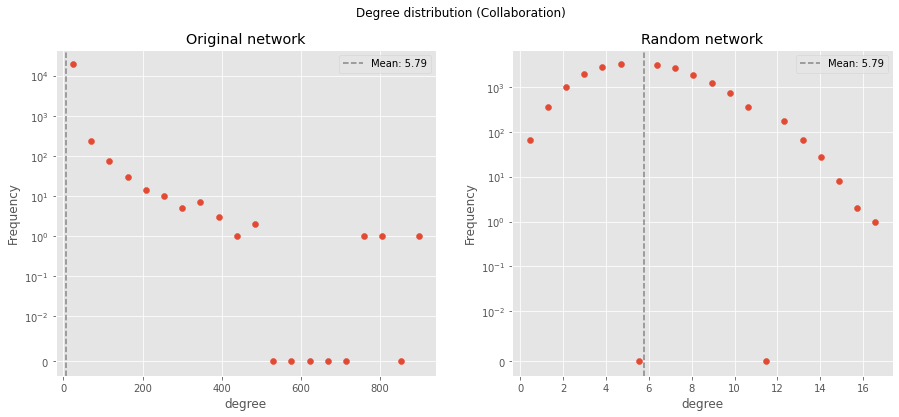

In [18]:
# extract degree distribution from Collaboration network and random network 
degree_collab = list([deg for node, deg in G.degree])
degree_random_collab = list([deg for node, deg in G_collab_random.degree])
compare_distributions('Degree distribution (Collaboration)', degree_collab, degree_random_collab, "degree", log=True)

In [20]:
import random

def sample_shortest_path_lengths(G, n=1000):
    """
    Samples n shortest lengths from random pairs of n nodes in the network
    """
    
    sp_lengths = []
    
    # extract all nodes and shuffle order
    nodes = list((G.nodes()))
    random.shuffle(nodes)
    
    # get all pairs of n nodes and shuffle pairs
    node_pairs = list(itertools.combinations(nodes[:n], 2))
    random.shuffle(node_pairs)
    
    # take shortest path length until n lengths is reached
    for source, target in node_pairs:
        if not nx.has_path(G, source, target):
            continue
            
        sp_lengths.append(len(nx.shortest_path(G, source, target)))
        if len(sp_lengths) > n:
            break
    
    return sp_lengths

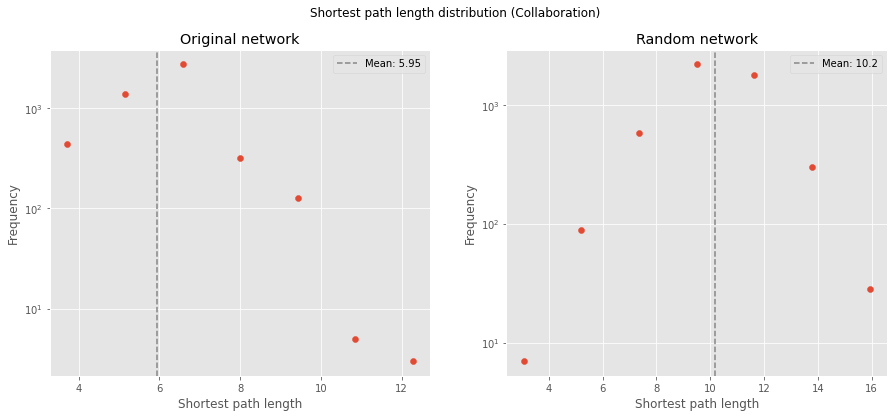

In [21]:
# sample 5000 shortest path lengths from each network
shortest_paths_collab = sample_shortest_path_lengths(G, n=5000)
shortest_paths_random_collab = sample_shortest_path_lengths(G_collab_random, n=5000)

compare_distributions('Shortest path length distribution (Collaboration)', 
                      shortest_paths_collab, shortest_paths_random_collab, 
                      "Shortest path length", log=True, bins = 7)

# Notebook 5

In [48]:
def plot_component_distributions(G_original, G_configuration, title, 
                                 component_method=nx.connected_components):
    """
    Visualizes component size distributions for a network and its configuration 
    network counterpart. Does not use binning.
        @G_original (NetworkX Graph): Original network
        @G_configuration (NetworkX Graph): Configuration network
        @title (str): Plot title
        @component_method: NetworkX method to extract components, e.g. nx.connected_components
    """
    
    # get number of nodes for normalization
    num_nodes = nx.number_of_nodes(G_original)
    
    # count distinct values using Counter. Normalize component sizes by number of nodes
    cnt_original = Counter([len(comp) / num_nodes for comp in component_method(G_original)])
    cnt_configuration = Counter([len(comp) / num_nodes for comp in component_method(G_configuration)])
    
    fig, ax = plt.subplots()
    # plot counter values using scatter plots
    ax.scatter(x=list(cnt_original.keys()), y=list(cnt_original.values()), 
               label='Original network', s=100)
    ax.scatter(x=list(cnt_configuration.keys()), y=list(cnt_configuration.values()), 
               label='Configuration network', s=100)
    
    # set log-log scale
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # set x-axis limits such that components with 1 node and all nodes will be visible
    ax.set_xlim((1 / num_nodes) * 0.8, 1.1)
    
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("Proportion of nodes in component")
    ax.set_ylabel("Frequency")

    plt.show()
    
def make_configuration_model(G):
    """
    Constructs a configuration model corresponding to the given network
        @G (NetworkX Graph or Digraph)
    Returns
        NetworkX MultiGraph or MultiDiGraph
    """
    
    # if graph is directed, use make_directed_configuration_model()
    if nx.is_directed(G):
        return make_directed_configuration_model(G)
    
    # initialize multi-graph
    conf_model = nx.MultiGraph()
    
    # get degree sequence
    degree_seq = list(dict(G.degree).values())
    
    stubs = []
    
    # loop over each node degree and add stubs as tuples
    for idx, degree in enumerate(degree_seq):    
        for i in range(degree):
            stubs.append( (idx, i) )
    
    while len(stubs) > 0:
        # pop two stubs at random positions
        stub1 = stubs.pop(random.randint(0, len(stubs) - 1))
        stub2 = stubs.pop(random.randint(0, len(stubs) - 1))
        
        # add edge between nodes in each stub
        conf_model.add_edge(stub1[0], stub2[0])
    
    return conf_model

def make_directed_configuration_model(G):
    """
    Constructs a configuration model corresponding to the given directed network
        @G (NetworkX DiGraph)
    Returns
        NetworkX MultiDiGraph
    """
    
    conf_model = nx.MultiDiGraph()
    
    # get degree sequences
    in_degree_seq = list(dict(G.in_degree).values())
    out_degree_seq = list(dict(G.out_degree).values())
    
    in_stubs = []
    out_stubs = []
    
    # loop over each node in-degree and add stubs as tuples
    for idx, degree in enumerate(in_degree_seq):    
        for i in range(degree):
            in_stubs.append( (idx, i) )
            
    # loop over each node out-degree and add stubs as tuples
    for idx, degree in enumerate(out_degree_seq):    
        for i in range(degree):
            out_stubs.append( (idx, i) )
    
    # loop over each out-degree stub and connect to a random in-degree stub
    for node, edgenum in out_stubs:
        in_stub = in_stubs.pop(random.randint(0, len(in_stubs) - 1))
        conf_model.add_edge(node, in_stub[0])
    
    return conf_model

In [38]:
# create Collaboration configuration model
email_conf = make_configuration_model(G)
print("Original Collaboration network:")
print(nx.info(G))

print("\n\nCollaboration network configuration model:")
print(nx.info(collab_conf))
print("Number of self-loops: {}"
     .format(nx.number_of_selfloops(collab_conf)))

Original Collaboration network:
Name: 
Type: DiGraph
Number of nodes: 19478
Number of edges: 56378
Average in degree:   2.8944
Average out degree:   2.8944


Collaboration network configuration model:
Name: 
Type: MultiDiGraph
Number of nodes: 19478
Number of edges: 56378
Average in degree:   2.8944
Average out degree:   2.8944
Number of self-loops: 25


As we can see, the configuration model has self-loops, and we can also expect it to contain multi-links. We know, however, that the expected number of self-loops and multi-links goes to zero in the N → ∞ limit. 

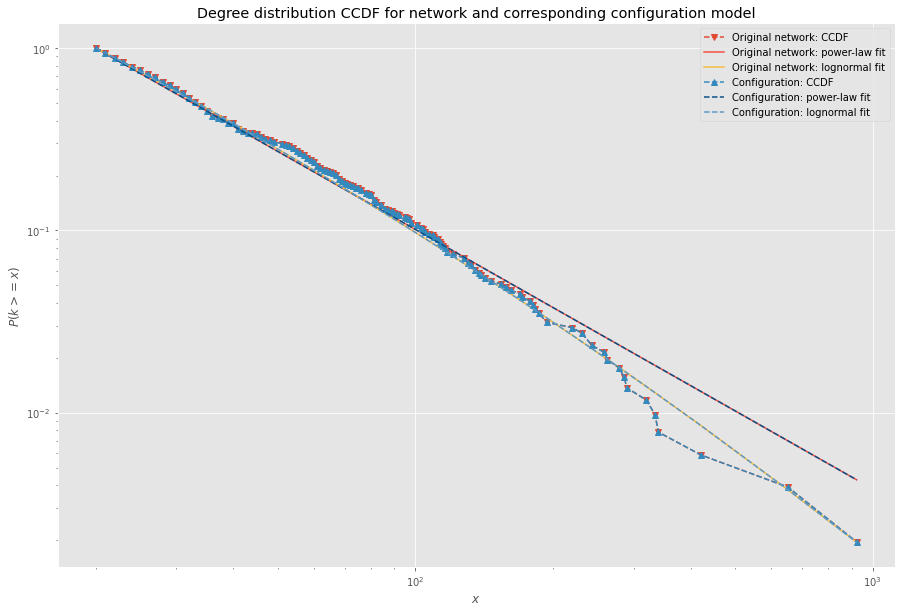

In [39]:
# extract in-degree distributions
email_fitoutput_in = powerlaw.Fit(list(dict(G.in_degree).values()), verbose=False)
email_configuration_fitoutput_in = powerlaw.Fit(list(dict(email_conf.in_degree).values()), verbose=False)

plot_ccdf_with_fits(email_fitoutput_in, email_configuration_fitoutput_in)

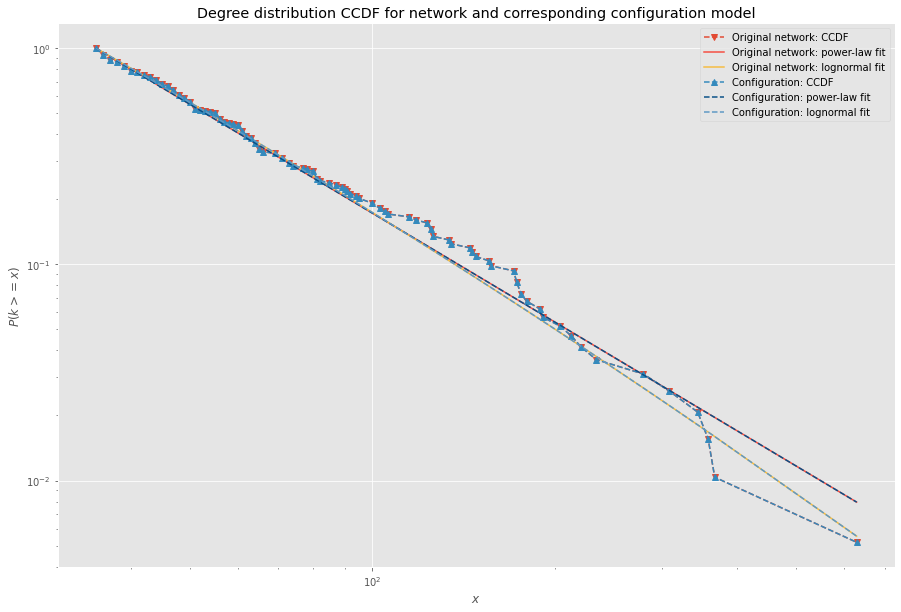

In [40]:
# extract and compare out-degree distributions
email_fitoutput_out = powerlaw.Fit(list(dict(G.out_degree).values()), verbose=False)
email_configuration_fitoutput_out = powerlaw.Fit(list(dict(email_conf.out_degree).values()), verbose=False)
plot_ccdf_with_fits(email_fitoutput_out, email_configuration_fitoutput_out)

In [30]:
def compare_distributions(title, dist1, dist2, xlabel, log=False, bins=20):
    """
    Plots two distributions on a single plot. 
    Plots histogram output as scatter plot with x-ticks marking bin centers 
        @title: plot title
        @dist1 (list): distribution from original network
        @dist2 (list): ditribution from random network null model
        @xlabel (str): label on x-axis
        @log (boolean): If True, logscales y-axis
        @bins (int or list): number of histogram bins or list with pre-defined bin edges
    """
        
    # get histogram scatter points of distribution 1
    n_1, x_1, _ = plt.hist(dist1, bins = bins)
    bin_centers_1 = 0.5*(x_1[1:]+x_1[:-1])
    plt.close()
    
    # get histogram scatter points of distribution 2
    n_2, x_2, _ = plt.hist(dist2, bins = bins)
    bin_centers_2 = 0.5*(x_2[1:]+x_2[:-1])
    plt.close()
    
    # initilize subplots
    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
    
    # set y logscale if specified
    if log:
        ax1.set_yscale("symlog")

    
    # plot distribution from original network
    ax1.scatter(bin_centers_1, n_1, label='Original network', s=100)
    
    # add mean as vertical line
    ax1.axvline(x=np.mean(dist1), label='Org. network mean: {:.3}'.format(np.mean(dist1)), 
                color='#f2ada2', linestyle='--')
    
    
    # if bins is list, set x-ticks as bin centers and rotate xlabels 
    if isinstance(bins, list):
        ax1.set_xticks(bin_centers_1)
        ax1.set_xlim(min(bins), max(bins))
        ax1.tick_params(axis='x', labelrotation=90)

    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("Frequency")
        
    # plot distribution from Configuration network
    ax1.scatter(bin_centers_2, n_2, label='Configuration network', s=100)
    ax1.axvline(x=np.mean(dist2), label='Conf. network mean: {:.3}'.format(np.mean(dist2)), 
                color='#9fc1d6', linestyle='--')

    ax1.legend(loc='best')

    plt.show()

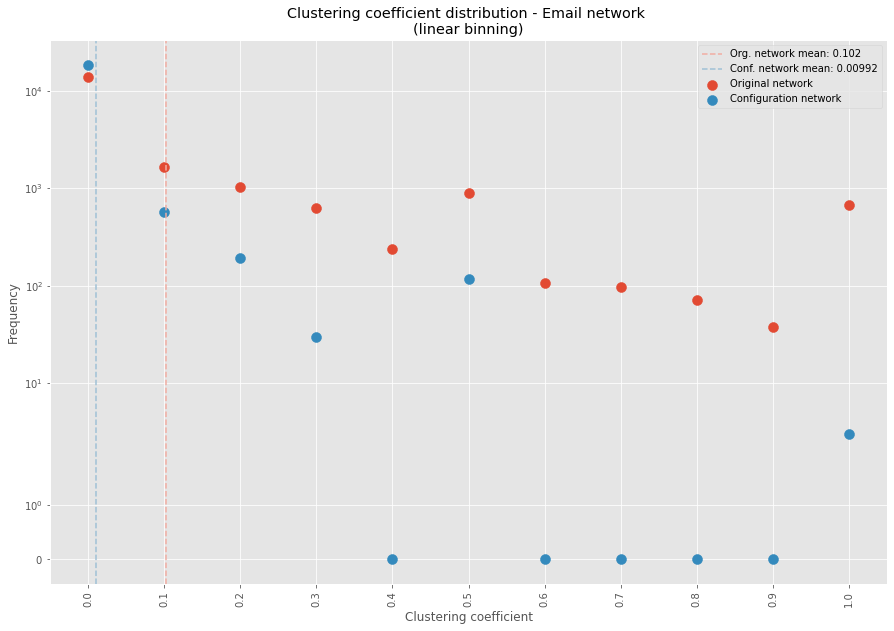

In [41]:
email_cc_dist = list(dict(nx.clustering(G)).values())
email_configuration_cc_dist = list(dict(nx.clustering(nx.DiGraph(email_conf))).values())

compare_distributions('Clustering coefficient distribution - Email network \n(linear binning)', 
                      email_cc_dist, email_configuration_cc_dist, "Clustering coefficient", 
                      log=True, bins=[-0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 
                                      0.55, 0.65, 0.75, 0.85, 0.95, 1.05])

In [32]:
def sample_shortest_path_lengths(G, n=1000):
    """
    Samples n shortest lengths from random pairs of n nodes in the network
    """
    sp_lengths = []
    
    # extract all nodes and shuffle order
    nodes = list((G.nodes()))
    random.shuffle(nodes)
    
    # get all pairs of n nodes and shuffle pairs
    node_pairs = list(itertools.combinations(nodes[:n], 2))
    random.shuffle(node_pairs)
    
    # take shortest path length until n lengths is reached
    for source, target in node_pairs:
        if not nx.has_path(G, source, target):
            continue
            
        sp_lengths.append(len(nx.shortest_path(G, source, target)))
        if len(sp_lengths) > n:
            break
    
    return sp_lengths

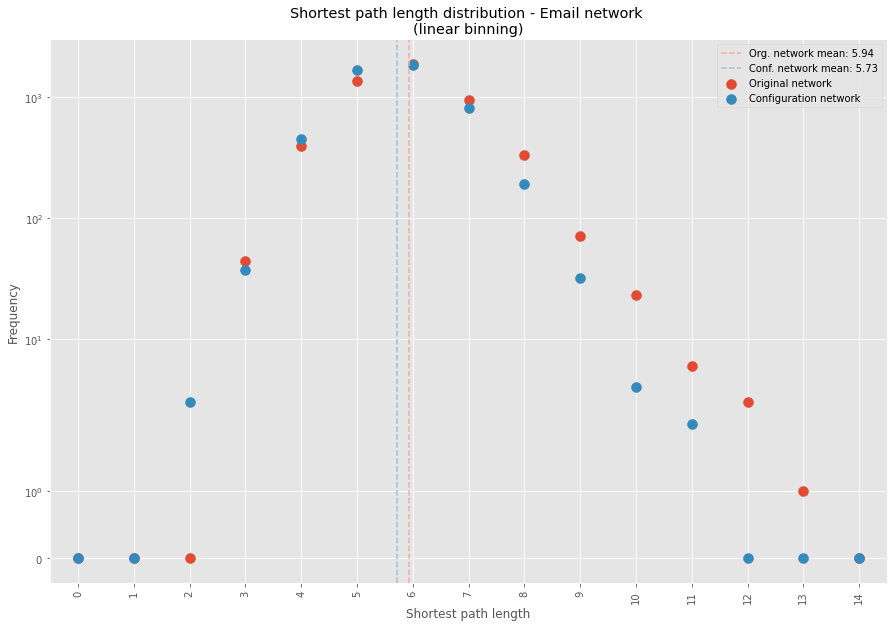

In [57]:
# sample 5000 shortest path lengths from each network
shortest_paths_email = sample_shortest_path_lengths(G, n=5000)
shortest_paths_email_configuration = sample_shortest_path_lengths(email_conf, n=5000)

compare_distributions('Shortest path length distribution - Email network \n(linear binning)', 
                      shortest_paths_email, shortest_paths_email_configuration, 
                      "Shortest path length", log=True, 
                      bins=list(np.linspace(-0.5, 14.5, 16, endpoint=True))) # note that max is hard-set to 14.5

Number of weakly connected components in Email network: 440
Number of weakly connected components in corresponding configuration network: 417


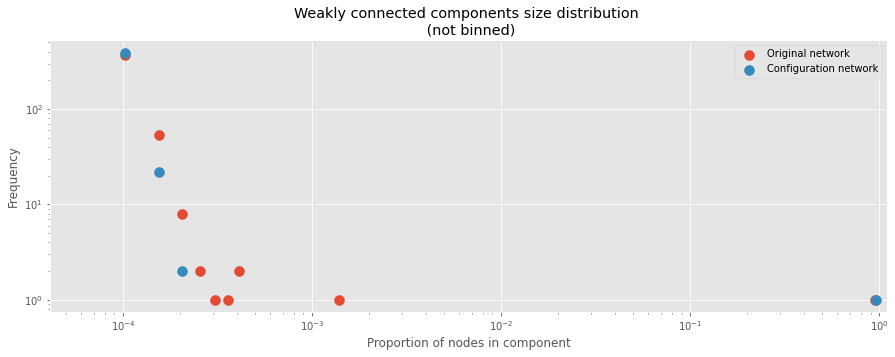

In [49]:
print("Number of weakly connected components in Email network: {}"
      .format(nx.number_weakly_connected_components(G)))
print("Number of weakly connected components in corresponding configuration network: {}"
      .format(nx.number_weakly_connected_components(email_conf)))

plot_component_distributions(G, email_conf, 
                             "Weakly connected components size distribution \n (not binned)", 
                             component_method=nx.weakly_connected_components)

Number of strongly connected components in Email network: 13860
Number of strongly connected components in corresponding configuration network: 14111


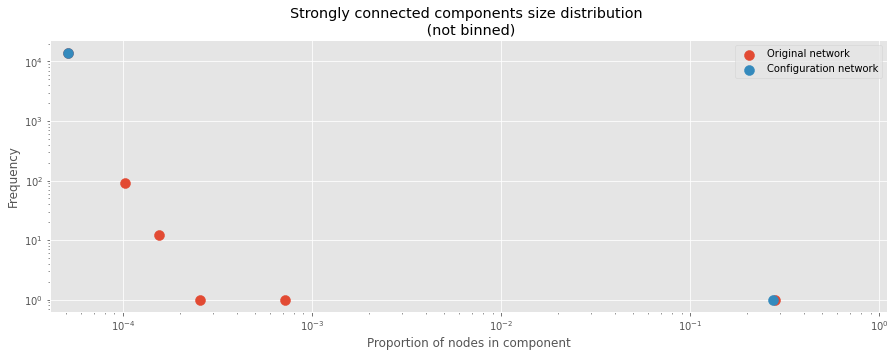

In [50]:
print("Number of strongly connected components in Email network: {}"
      .format(nx.number_strongly_connected_components(G)))
print("Number of strongly connected components in corresponding configuration network: {}"
      .format(nx.number_strongly_connected_components(email_conf)))

plot_component_distributions(G, email_conf, 
                             "Strongly connected components size distribution \n (not binned)", 
                             component_method=nx.strongly_connected_components)

#### Centrality distribution (eigenvector centrality)  

Finally, we can compare the distribution of centrality scores such as eigenvector centrality:

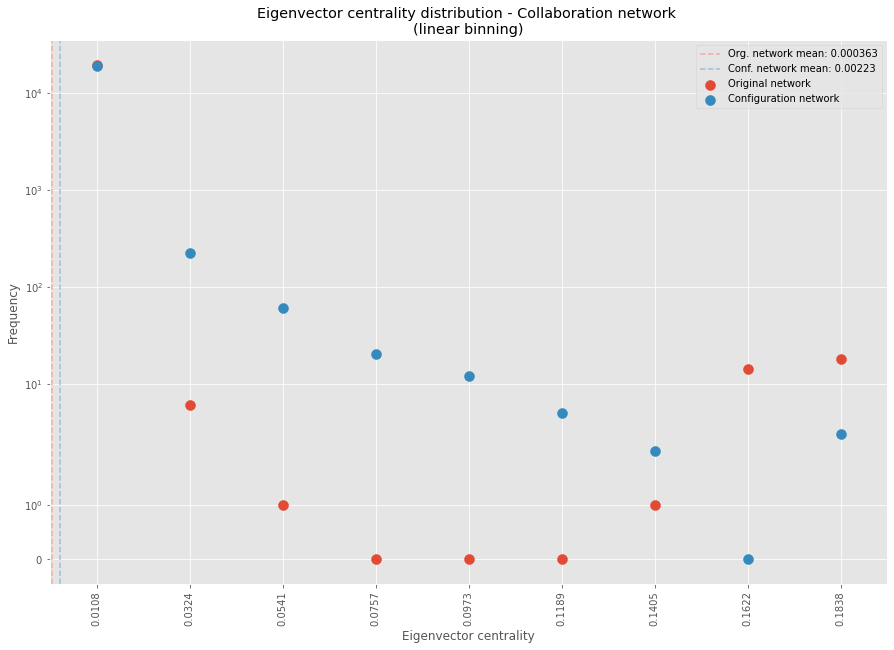

In [58]:
# extract eigenvector centrality with default parameters using NetworkX
collab_cc_centrality = list(dict(nx.eigenvector_centrality(G)).values())
collab_configuration_centrality = list(dict(nx.eigenvector_centrality(nx.Graph(collab_conf))).values())

# plot distributions with 10 linear bins
compare_distributions('Eigenvector centrality distribution - Collaboration network \n(linear binning)', 
                      collab_cc_centrality, collab_configuration_centrality, "Eigenvector centrality", 
                      log=True, bins=list(np.linspace(min(collab_cc_centrality + collab_configuration_centrality), 
                                                      max(collab_cc_centrality + collab_configuration_centrality),
                                                      10, endpoint=True)))